# Kaggle - Mpred
## Predicitive Maintenance Challenge
### https://www.kaggle.com/c/mpred-datascience-challenge
#### By: 55thSwiss


## Introduction

A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant 
costs that are associated with delays in the production process due to mechanical problems. Most of these 
businesses are interested in predicting these problems in advance so that they can proactively prevent the 
problems before they occur which will reduce the costly impact caused by downtime.

The business problem for this example is about predicting problems caused by component failures such that 
the question “What is the probability that a machine will fail in the near future due to a failure of a 
certain component” can be answered. The problem is formatted as a multi-class classification problem and 
a machine learning algorithm is used to create the predictive model that learns from historical data collected 
from machines.

The goal is to predict when a given machine will fail within 24 hours due to a failure of a given component .

## Sources

Please refer to the playbook [1] for predictive maintenance for a detailed explanation of common use cases 
in predictive maintenance and modelling approaches.

Original data set can be found at [2]

[1] https://docs.microsoft.com/fr-fr/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance

[2] https://www.kaggle.com/yuansaijie0604/xinjiang-pm/data

## Data Description

In this competition, you are asked to estimate the probability that a machine will fail in the near future due to a 
failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in 
the next 24 hours due to a certain component failure (component 1,2,3 or 4) hence you are asked to classify the 
observations into 5 categories : comp1, comp2,comp3,comp4 and none (e.g : The machine will fail due to 
component 1... 4 or will not fail in the next 24h).

## TRAIN/SPLIT

The data is made of 5 different data set : Errors, Failures, Machines features, Maintenance history and Telemetry which contains the historical data collected from 100 different machines

The training set contains the data of 70 machines while the test set contains the data of the 30 remaining machines

The data is collected every hour for a year. For simplicity, you are asked to group the data into 3 hours windows.

## File descriptions

__telemetry.csv__ The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 70 machines in real time averaged over every hour collected during the year 2015

__errors.csv__ The errors logs are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

__maint.csv__ This file contains the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a break down. The records that are created due to break downs will be called failures which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

__machines.csv__ This data set includes some information about the machines which are model type and years in service.

__failures.csv__ These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Data fields

__volt, rotate, pressure, vibration__ Voltage, rotation, pressure and vibration measurements collected from the machines

__machineID__ The ID of a machine

__datetime__ The date

__errorID__ The ID of an error

__comp__ The component replaced during the scheduled maintenance

__model__ Model of the machine

__age__ Years in service

__errorID__ The ID of an error

__failure__ Failed component type

### First assessment
There has been a problem defined that forms the objective of the project and we've also been given the data to work with. Typically this would be steps one __(1)__ and two __(2)__ respectively, gaining an understanding of the business and defining the problem (an absolute precursor to deciding requirements and method of solution) as well as collecting the data, in this case from the manufacturing floor.

### Wrangling or preparing the data for consumption
There are a few requirements from the introduction on the formatting of the data and how it should be proceesed. In this step the data will be formatted as well as examined for it's architecture in regards to storage and processing, and an initial cleaning for aberrant, missing, duplicate, or outlier data points within each dataset. This is a good point to determine possible independent and dependent variables.  If a key feature has been identified, the dataframes will be easily concatenated, otherwise it will be done "manually". Lastly, the cumulative dataframe can be split into training, test, and validation tables. 

In [1550]:
#libraries
import sys
import os
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import seaborn as sns
import sklearn
from sklearn.preprocessing import minmax_scale
import datetime
import warnings
warnings.filterwarnings('ignore')

#vizualization defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

The first dataset I tried looking at was telemetry.csv, but an error kicked up when loading the CSV:

```ParserError: Error tokenizing data. C error: Expected 6 fields in line 92490, saw 9```

This likely kicked up from missing information, meaning cells that were void of any value. Opening in a spreadsheet editor like Excel often fixes this by replacing the empty cells with a NaN status. 

In [1551]:
#import data
sensorData = pd.read_csv('PdM_telemetry.csv')
maintenanceData = pd.read_csv('PdM_maint.csv')
originsData = pd.read_csv('PdM_machines.csv')
failureData = pd.read_csv('PdM_failures.csv')
errorData = pd.read_csv('PdM_errors.csv')

We'll do a first run through starting with 'telemetry.csv' since this is the largest dataset, then finish up the rest quickly. After opening the csv in Excel we're able to import it into the notebook but it has three columns of entirely null values. I've confirmed this is just an anomaly and the csv is infact empty in those columns (seems to be a formatting error, one row contained a shifted column heading in the data cells), they will be dropped. 

### Telemetry Data:

This is is going to be the most valuable dataset inidivudally, as it contains a vast amount of sensor readings from one hundred different machines. This will probably be the foundation dataset for merging.

In [1552]:
#first look
sensorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968589 entries, 0 to 968588
Data columns (total 9 columns):
datetime      968589 non-null object
machineID     968589 non-null int64
volt          968589 non-null float64
rotate        968589 non-null object
pressure      968589 non-null object
vibration     968589 non-null object
Unnamed: 6    1 non-null object
Unnamed: 7    1 non-null object
Unnamed: 8    1 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 66.5+ MB


In [1553]:
sensorData.sample(3)

,datetime,machineID,volt,rotate,pressure,vibration,Unnamed: 6,Unnamed: 7,Unnamed: 8
182875,4/26/2015 22:00,11,163.984270,445.157,122.379,43.4884,NaN,NaN,NaN
743096,4/6/2015 19:00,75,223.802471,346.521,104.259,38.6304,NaN,NaN,NaN
670776,1/3/2015 19:00,67,157.242611,466.124,86.1231,35.7007,NaN,NaN,NaN


In [1554]:
# row index 92488 was the problem data from above, drop the row and clean up columns
sensorData.drop(92488, inplace = True)
sensorData.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], axis=1, inplace=True)
sensorData['datetime'] = pd.to_datetime(sensorData['datetime'], infer_datetime_format = True)
#the line below was working when 'sensorData' was 'telemetry', but after it started dropping 'datatime' and 'machineID'?
#sensorData = sensorData.loc[:, ('rotate', 'pressure', 'vibration')] = sensorData.loc[:, ('rotate', 'pressure', 'vibration')].astype(dtype=float)
sensorData['rotate'] = sensorData['rotate'].astype(float)
sensorData['pressure'] = sensorData['pressure'].astype(float)
sensorData['vibration'] = sensorData['vibration'].astype(float)
sensorData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968588 entries, 0 to 968588
Data columns (total 6 columns):
datetime     968588 non-null datetime64[ns]
machineID    968588 non-null int64
volt         968588 non-null float64
rotate       968588 non-null float64
pressure     968588 non-null float64
vibration    968588 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 51.7 MB


In [1555]:
# check out some statistics on the dataset
sensorData.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,170.774119,446.591205,100.841515,40.383648
std,30.450409,15.507488,52.701718,11.028763,5.366198
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,18.000000,160.298184,412.278255,93.492369,36.778303
50%,45.000000,170.597611,447.555368,100.414332,40.237433
75%,73.000000,181.006196,482.154486,107.535244,43.781329
max,100.000000,255.124717,695.020984,185.951998,76.791072


It looks like every feature has data points that are well outside three standard deviations of their respective mean. The outliers need to be looked at and dealt with if they're determined to be noise in the dataset, although these could be triggers corresponding to the failure mode in so they won't be removed just yet.

In [1556]:
sensorData.shape

(968588, 6)

In [1557]:
# due to this dataset being so large, we're going to start organzing by date to 
sensorData.sort_values(by=['datetime'], inplace = True)

In [1558]:
mask = sensorData['machineID'] == 1
sensorData[mask]

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
92489,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
92490,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
92491,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
92492,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
92493,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [1559]:
# looking at the results above, their appears to be duplicated data, investigate a litte here:
sum(sensorData[mask].duplicated('datetime'))

8761

In [1560]:
# cleaning the duplicate data and check
sensorData.drop_duplicates(subset=['datetime', 'machineID', 'volt'], inplace = True)
sum(sensorData[mask].duplicated('datetime'))

0

In [1561]:
# looks better, check a 24 hour period of another machine for consistancy
mask = sensorData['machineID'] == 2
sensorData[mask].head(24)

,datetime,machineID,volt,rotate,pressure,vibration
8761,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
8762,2015-01-01 07:00:00,2,158.282044,432.372960,110.907806,37.267114
101252,2015-01-01 08:00:00,2,168.242028,454.629639,97.877007,39.709461
101253,2015-01-01 09:00:00,2,180.280316,438.391022,84.440430,40.490443
101254,2015-01-01 10:00:00,2,169.719531,473.055664,110.395683,41.229578
101255,2015-01-01 11:00:00,2,191.257247,369.738792,101.223451,45.616543
8767,2015-01-01 12:00:00,2,186.282977,483.698416,115.061863,50.690561
101257,2015-01-01 13:00:00,2,179.367188,450.943961,94.378019,38.684815
101258,2015-01-01 14:00:00,2,168.893782,494.876313,101.910022,34.566681
101259,2015-01-01 15:00:00,2,158.595797,427.282619,92.470163,32.160232


In [1562]:
# organize the dataframe by 'machineID' first, then 'datetime'
sensorData.sort_values(['machineID', 'datetime'], inplace = True)

In [1563]:
# remove after
mask = sensorData['machineID'] == 2
sensorData[mask].head(3)

,datetime,machineID,volt,rotate,pressure,vibration
8761,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
8762,2015-01-01 07:00:00,2,158.282044,432.372960,110.907806,37.267114
101252,2015-01-01 08:00:00,2,168.242028,454.629639,97.877007,39.709461


In [1564]:
# aggregate a moving average every three hours of the sensor data and populate new features 'key_ma'
# fill the NaN cells created in the first two rows from '.rolling()' with the mean to 'key_ma'
for key in ['volt', 'rotate', 'pressure', 'vibration']:
    movingAv = (key + '_ma')
    sensorData[movingAv] = sensorData[key].rolling(3).mean()
    colMean = sensorData[movingAv].mean()
    sensorData[movingAv].fillna((colMean), inplace = True)
    
# select every third row per train/split requirements
# semi working...
#i = 1
#sensorData['machineID'] = sensorData['machineID'].astype(str)
#for it, mach in enumerate(sensorData['machineID']):
    #i = (i + 1)
#    if int(mach) == i:
#        print(mach, i)
#        i = (i + 1)             
        
        
#kind working?
#sensorData = sensorData.iloc[::3, :].loc[sensorData['machineID'] == mach]

#sensorData.loc[sensorData['machineID'] == mach]
#sensorData = sensorData.iloc[::3, :]

In [1565]:
sensorData.shape

(876100, 10)

Telemetry sensor data looks clean enough for the first pass, there are no missing values, the features have been converted to appropriate data types, and the dataframe has been reduced into three hour incremenets with averaged sensor data.

### Maintenance Data

I'm not sure how usefule the maintenanceData is going to be, from the description this csv contains components that were changed due to scheduled maintenance and failures. At the same time, the failures are logged in a separate dataset, which will likely be more pertinent to our model. After cleaning all the datasets we can compare the scheduled changes and failures to the failureData csv and check for duplication, completeness, etc.

In [1566]:
maintenanceData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
datetime     3286 non-null object
machineID    3286 non-null int64
comp         3286 non-null object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


In [1567]:
maintenanceData.shape

(3286, 3)

In [1568]:
maintenanceData.describe()

,machineID
count,3286.000000
mean,50.284236
std,28.914478
min,1.000000
25%,25.250000
50%,50.000000
75%,75.000000
max,100.000000


In [1569]:
maintenanceData.sample(3)

,datetime,machineID,comp
2652,2015-06-01 06:00:00,81,comp1
2260,2015-05-20 06:00:00,69,comp2
425,2015-08-09 06:00:00,13,comp2


In [1570]:
# change 'datetime' to_datetime :)
maintenanceData['datetime'] = pd.to_datetime(maintenanceData['datetime'], infer_datetime_format = True)
# remove the begnning characters from 'comp' column and # change 'comp' to an integer
maintenanceData['comp'] = maintenanceData['comp'].str[4:].astype(int)
# change 'comp' to an integer
#maintenanceData['comp'] = maintenanceData['comp'].astype(int)

maintenanceData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
datetime     3286 non-null datetime64[ns]
machineID    3286 non-null int64
comp         3286 non-null int32
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 64.3 KB


In [1571]:
# check for duplicated rows by 'datetime' and 'machineID' to consolidate rows
maintenanceData.duplicated(['datetime', 'machineID']).sum()

758

In [1572]:
#This first concatenates your dataframe and the output of the get_dummies call, then it 
#groups the result according to the relevant columns, takes the sum of those columns among 
#those groups and then resets the index so you don't have to deal with a multi-index data 
#frame. The result looks like:
maintenanceData = pd.concat([maintenanceData, pd.get_dummies(maintenanceData.comp)], 1).groupby(['datetime','machineID']).sum().reset_index()
maintenanceData.drop(['comp'], axis=1, inplace=True)

In [1573]:
maintenanceData.duplicated(['datetime', 'machineID']).sum()

0

In [1574]:
maintenanceData.columns = ['datetime', 'machineID', 'mComp_1', 'mComp_2', 'mComp_3', 'mComp_4']
maintenanceData.sample(1)

,datetime,machineID,mComp_1,mComp_2,mComp_3,mComp_4
562,2015-02-08 06:00:00,30,0,1,0,1


### Origins Data

The vintage of each machine should add valuable correlation to the frequency of scheduled and failure component repairs.

In [1575]:
originsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
machineID    100 non-null int64
model        100 non-null object
age          100 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.4+ KB


In [1576]:
# remove the begnning characters from 'model' column and change to integer data type
originsData['model'] = originsData['model'].str[5:].astype(int)

In [1577]:
originsData.shape

(100, 3)

In [1578]:
originsData['age'].describe()

count    100.000000
mean      11.330000
std        5.856974
min        0.000000
25%        6.750000
50%       12.000000
75%       16.000000
max       20.000000
Name: age, dtype: float64

In [1579]:
originsData.sample(5)

,machineID,model,age
68,69,2,19
80,81,4,1
60,61,4,2
98,99,1,14
0,1,3,18


In [1580]:
# quantity of each machine by model
originsData.model.value_counts().sort_index()

1    16
2    17
3    35
4    32
Name: model, dtype: int64

In [1581]:
# quantity of each machine by age
originsData.age.value_counts().sort_index()

0      1
1      3
2      6
3      4
4      3
5      4
6      4
7      6
8      1
9      5
10    10
11     2
12     2
14    14
15     6
16     5
17     7
18     6
19     4
20     7
Name: age, dtype: int64

In [1582]:
#plt.figure(figsize=(7,5))
#plt.scatter('age', 'machineID', data = originsData)
#plt.ylabel('Machine ID')
#plt.xlabel('Age')

### Failure Data

This will obviously contain critical features to predicting future failures.

In [1583]:
failureData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
datetime     761 non-null object
machineID    761 non-null int64
failure      761 non-null object
dtypes: int64(1), object(2)
memory usage: 17.9+ KB


In [1584]:
failureData.sample(3)

,datetime,machineID,failure
77,2015-08-24 06:00:00,13,comp3
131,2015-02-27 06:00:00,19,comp4
128,2015-09-12 06:00:00,18,comp2


In [1585]:
failureData['failure'] = failureData['failure'].str[4:].astype(int)
failureData['datetime'] = pd.to_datetime(failureData['datetime'], infer_datetime_format = True)

In [1586]:
failureData.head(3)

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,4
1,2015-03-06 06:00:00,1,1
2,2015-04-20 06:00:00,1,2


In [1587]:
failureData['failure'].describe()

count    761.000000
mean       2.390276
std        1.102084
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: failure, dtype: float64

In [1588]:
# check for duplicated rows by 'datetime' and 'machineID' to consolidate rows
failureData.duplicated(['datetime', 'machineID']).sum()

42

In [1589]:
#This first concatenates your dataframe and the output of the get_dummies call, then it 
#groups the result according to the relevant columns, takes the sum of those columns among 
#those groups and then resets the index so you don't have to deal with a multi-index data 
#frame. The result looks like:
failureData = pd.concat([failureData, pd.get_dummies(failureData.failure)], 1).groupby(['datetime','machineID']).sum().reset_index()
failureData.drop(['failure'], axis=1, inplace=True)

In [1590]:
# confirm
failureData.duplicated(['datetime', 'machineID']).sum()

0

In [1591]:
failureData.columns = ['datetime', 'machineID', 'fComp_1', 'fComp_2', 'fComp_3', 'fComp_4']
failureData.head()

,datetime,machineID,fComp_1,fComp_2,fComp_3,fComp_4
0,2015-01-02 03:00:00,16,1,0,1,0
1,2015-01-02 03:00:00,17,0,0,0,1
2,2015-01-02 03:00:00,22,1,0,0,0
3,2015-01-02 03:00:00,35,1,0,0,0
4,2015-01-02 03:00:00,45,1,0,0,0


### Error Data

We're going to see if there is a correlation between the errors generated on the machines, and eventual component maintenance / failure.

In [1592]:
errorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null object
machineID    3919 non-null int64
errorID      3919 non-null object
dtypes: int64(1), object(2)
memory usage: 91.9+ KB


In [1593]:
errorData.sample(3)

,datetime,machineID,errorID
2578,2015-09-27 06:00:00,67,error1
69,2015-02-05 06:00:00,3,error1
2111,2015-05-03 01:00:00,55,error2


In [1594]:
errorData['errorID'] = errorData['errorID'].str[5:].astype(int)
errorData['datetime'] = pd.to_datetime(errorData['datetime'], infer_datetime_format = True)

In [1595]:
errorData.head(3)

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,1
1,2015-01-03 20:00:00,1,3
2,2015-01-04 06:00:00,1,5


In [1596]:
errorData.duplicated(['datetime', 'machineID']).sum()

303

In [1597]:
#This first concatenates your dataframe and the output of the get_dummies call, then it 
#groups the result according to the relevant columns, takes the sum of those columns among 
#those groups and then resets the index so you don't have to deal with a multi-index data 
#frame. The result looks like:
errorData = pd.concat([errorData, pd.get_dummies(errorData.errorID)], 1).groupby(['datetime','machineID']).sum().reset_index()
errorData.drop(['errorID'], axis=1, inplace=True)

In [1598]:
# confirm
errorData.duplicated(['datetime', 'machineID']).sum()

0

In [1599]:
errorData.columns = ['datetime', 'machineID', 'error_1', 'error_2', 'error_3', 'error_4', 'error_5']
errorData.head()

,datetime,machineID,error_1,error_2,error_3,error_4,error_5
0,2015-01-01 06:00:00,24,1,0,0,0,0
1,2015-01-01 06:00:00,73,0,0,0,1,0
2,2015-01-01 06:00:00,81,1,0,0,0,0
3,2015-01-01 07:00:00,43,0,0,1,0,0
4,2015-01-01 08:00:00,14,0,0,0,1,0


### Merging, Futher Cleaning, and Feature Engineering

In [1600]:
singleDF = pd.merge(sensorData, maintenanceData, how = 'left', copy = False, on = ['datetime', 'machineID'])
singleDF = pd.merge(singleDF, errorData, how = 'left', copy = False, on = ['datetime', 'machineID'])
singleDF = pd.merge(singleDF, failureData, how = 'left', copy = False, on = ['datetime', 'machineID'])
singleDF = pd.merge(singleDF, originsData, how = 'left', copy = False, on = ['machineID'])
singleDF.drop(['volt_ma', 'rotate_ma', 'pressure_ma', 'vibration_ma'], axis=1, inplace=True)
singleDF.fillna(0, inplace=True)
for f in ['mComp_1', 'mComp_2', 'mComp_3', 'mComp_4', 'fComp_1', 'fComp_2', 'fComp_3', 'fComp_4', 'error_1', 'error_2', 'error_3', 'error_4', 'error_5']:
    #
    singleDF[f] = singleDF[f].astype(int)

In [1601]:
# sensorData was our base dataset, this confirms we're ending with the same number of rows we've started with
singleDF.shape

(876100, 21)

In [1602]:
singleDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876100 entries, 0 to 876099
Data columns (total 21 columns):
datetime     876100 non-null datetime64[ns]
machineID    876100 non-null int64
volt         876100 non-null float64
rotate       876100 non-null float64
pressure     876100 non-null float64
vibration    876100 non-null float64
mComp_1      876100 non-null int32
mComp_2      876100 non-null int32
mComp_3      876100 non-null int32
mComp_4      876100 non-null int32
error_1      876100 non-null int32
error_2      876100 non-null int32
error_3      876100 non-null int32
error_4      876100 non-null int32
error_5      876100 non-null int32
fComp_1      876100 non-null int32
fComp_2      876100 non-null int32
fComp_3      876100 non-null int32
fComp_4      876100 non-null int32
model        876100 non-null int32
age          876100 non-null int64
dtypes: datetime64[ns](1), float64(4), int32(14), int64(2)
memory usage: 100.3 MB


In [1603]:
singleDF.sample(3)

,datetime,machineID,volt,rotate,pressure,vibration,mComp_1,mComp_2,mComp_3,mComp_4,...,error_2,error_3,error_4,error_5,fComp_1,fComp_2,fComp_3,fComp_4,model,age
654196,2015-09-03 08:00:00,75,162.036541,345.920722,104.430883,55.991165,0,0,0,0,...,0,0,0,0,0,0,0,0,3,19
821746,2015-10-18 19:00:00,94,184.171438,382.850074,111.320510,44.830205,0,0,0,0,...,0,0,0,0,0,0,0,0,2,18
320774,2015-08-13 08:00:00,37,150.243375,511.045221,106.887612,36.405076,0,0,0,0,...,0,0,0,0,0,0,0,0,1,16


In [1604]:
# looking at a sample / head / tail the dataframe seemed sparse for the components 
# but doing several checks has revealed the indicators are there
a = singleDF['fComp_1'].value_counts()
b = singleDF['mComp_1'].value_counts()
c = singleDF['error_1'].value_counts()
print(a, b, c)

0    875908
1       192
Name: fComp_1, dtype: int64 0    875396
1       704
Name: mComp_1, dtype: int64 0    875090
1      1010
Name: error_1, dtype: int64


When I first saw a data set for performed maintenance, failures, and errors I assumed they should go together pretty simply. After looking at this last data set though, there are five different error messages, but we only have four unqiue components. Going back to look at the information provided at the beginning of this notebook, there is no useful information to define what these errors are or how they correlate at the maintenance level. After merging the data sets we're going to change all the error codes to 1, and do a simply binary categorization to see and correlation between the errors and maintenance/failures.

### Analysis

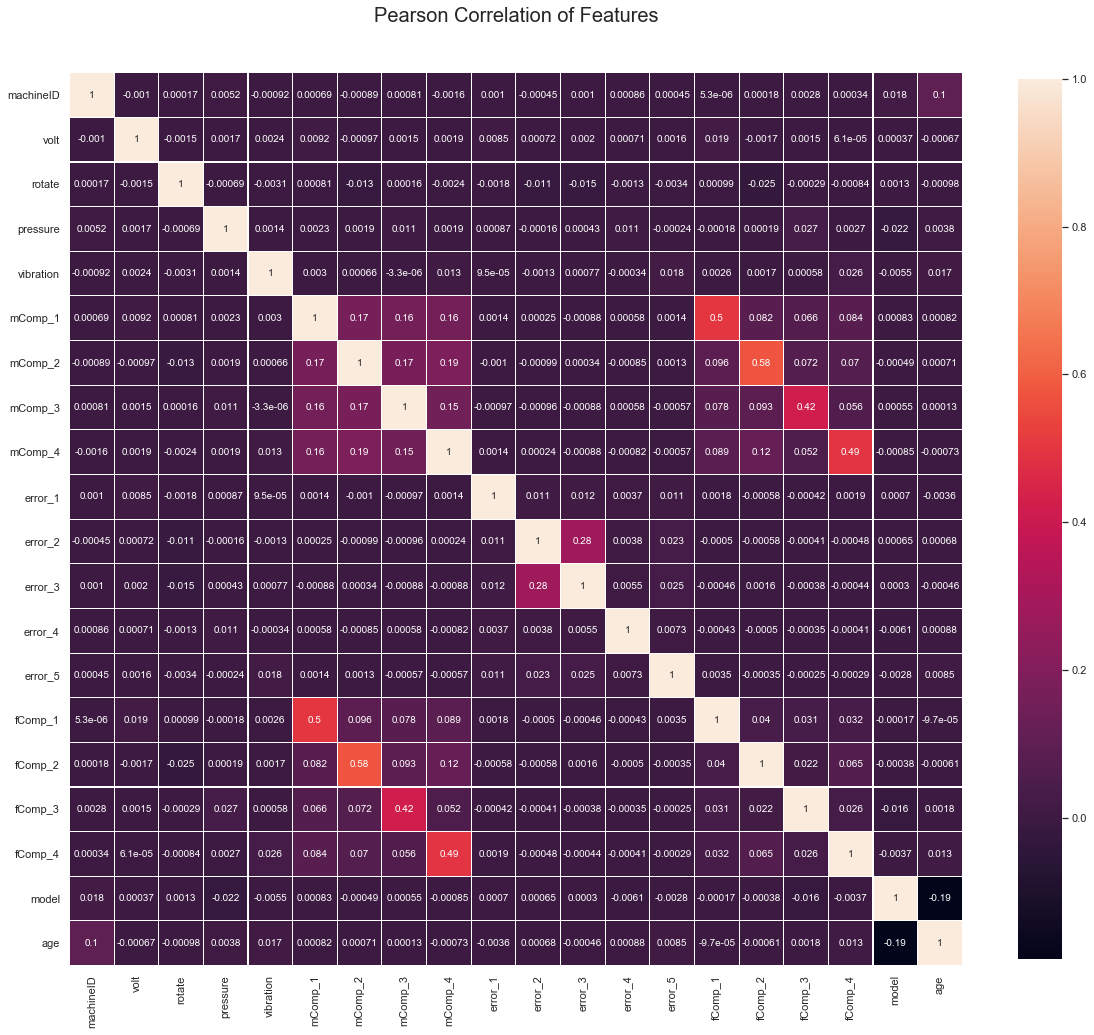

In [1611]:
# getting time for the first look

#correlation heatmap
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(20, 18))
    #olormap = sns.cubehelix_palette(start = 0, n_colors = 6, reverse = True)
    
    _ = sns.heatmap(
        df.corr(), 
        #cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':10 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=20)

correlation_heatmap(singleDF)

#### a look at indivual machines vs model vs age
sns.set(style="ticks", color_codes=True)
sns.pairplot(data = originsData)

#### look at the component usage graphically
plot = maintenanceData.plot.hist(alpha = .75, bins = 4, x = 'machineID', y = ['comp'],
                                 edgecolor='black', linewidth=1.2, xticks = [1,2,3,4],
                                 fontsize = 14, legend = True, figsize = (7, 5))
plt.title('Component Maintenance Distrobution', size = 18)
plt.xlabel('Component', size = 16)
plt.ylabel("Quantity", size = 16)
plt.legend(prop={'size': 12})
plt.xticks(range(1, 5))
plt.xlim([.25,4.75])

####  JUST FOOLING AROUND
sensorGraphData = sensorData
sensorGraphData[['volt_ma', 'rotate_ma', 'pressure_ma', 'vibration_ma']] = minmax_scale(sensorGraphData[['volt_ma', 'rotate_ma', 'pressure_ma', 'vibration_ma']])
mask = sensorGraphData['machineID'] == 55
sensorGraphData = sensorGraphData[mask]
sensorGraphData.drop(['volt', 'rotate', 'pressure', 'vibration', 'machineID'], axis = 1, inplace = True)
sensorGraphData = sensorGraphData.iloc[::730, :]
sensorGraphData.shape

####  JUST FOOLING AROUND
plot = sensorGraphData.plot.line(x = 'datetime', sharey = ['volt_ma', 'rotate_ma', 'pressure_ma', 'vibration_ma'], 
                                 title = 'Mach 55 Twelve Month Normalized Averages', legend = True)
plt.xlabel('Year')
plt.ylabel("Sensor Average")
L = plt.legend()
L.get_texts()[0].set_text('Voltage')
L.get_texts()[1].set_text('Rotation')
L.get_texts()[2].set_text('Pressure')
L.get_texts()[3].set_text('Vibration')